In [1]:
%pylab inline
import os, shutil

Populating the interactive namespace from numpy and matplotlib


Hyper parameters:

In [2]:
proportions = (0.6, 0.2, 0.2) # Proportions between train, validation and test set
batch_size = 16
epochs = 1

Remove existing directories and make new directories.

In [3]:
%%time
train_dir = './train'
valid_dir = './validation'
test_dir = './test'
all_dirs = [train_dir, valid_dir, test_dir]

for d in all_dirs:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.mkdir(d)
    os.mkdir(os.path.join(d,'NORMAL'))
    os.mkdir(os.path.join(d,'PNEUMONIA'))
print(os.listdir(train_dir))

['NORMAL', 'PNEUMONIA']
Wall time: 1.27 s


List all normal and pneumonia image paths in original train and test data.

In [4]:
%%time

orig_dir = 'chest_xray/train'
orig_dir2 = 'chest_xray/test'

normal_images = [os.path.join(orig_dir, 'NORMAL', x) for x in os.listdir(os.path.join(orig_dir, 'NORMAL')) if x.endswith('.jpeg')]
normal_images += [os.path.join(orig_dir2, 'NORMAL', x) for x in os.listdir(os.path.join(orig_dir2, 'NORMAL')) if x.endswith('.jpeg')]
pneumonia_images = [os.path.join(orig_dir, 'PNEUMONIA', x) for x in os.listdir(os.path.join(orig_dir, 'PNEUMONIA')) if x.endswith('.jpeg')]
pneumonia_images += [os.path.join(orig_dir2, 'PNEUMONIA', x) for x in os.listdir(os.path.join(orig_dir2, 'PNEUMONIA')) if x.endswith('.jpeg')]


print('Num of normal images:', len(normal_images))
print('Num of pneumonia images:', len(pneumonia_images))

Num of normal images: 1583
Num of pneumonia images: 4273
Wall time: 35.9 ms


Randomize the order of the images.

In [5]:
%%time
random.seed(1)
random.shuffle(normal_images)
random.shuffle(pneumonia_images)

Wall time: 0 ns


Copy the images from original directories to new ones and split them into train, validation and test folders.

In [6]:
%%time

# Splits given list into multiple lists with given proportions
def data_split(proportions, data):
    for x in np.split(data, np.cumsum(np.rint(np.dot(proportions, len(data))).astype(int))):
         yield x.tolist()

for directory, normals, pneumonias in zip(all_dirs, data_split(proportions, normal_images), 
                                                    data_split(proportions, pneumonia_images)):
    for file in normals + pneumonias:
        shutil.copyfile(file, os.path.join(directory, file.split('\\', 1)[1]))

Wall time: 6.62 s


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dg = ImageDataGenerator(rescale=1./255)

target_size = (150,150)
class_mode = 'binary'

train_generator = dg.flow_from_directory(
    train_dir, 
    target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False)

dev_generator = dg.flow_from_directory(
    valid_dir, 
    target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False)

test_generator = dg.flow_from_directory(
    test_dir, 
    target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False)

Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


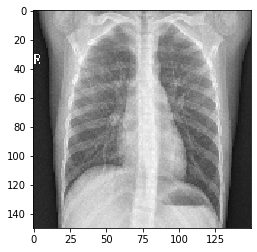

(150, 150, 3)

In [8]:
data_batch = train_generator[0][0]
imshow(data_batch[0])
show()
data_batch[0].shape

In [9]:
#Build and compile the model

from tensorflow.keras import models, layers

network = models.Sequential()
network.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same",input_shape=data_batch[0].shape))
network.add(layers.MaxPooling2D((2,2)))
network.add(layers.Conv2D(32, (3,3), activation = 'relu'))
network.add(layers.MaxPooling2D((2,2)))
network.add(layers.Conv2D(32, (3,3), padding = "same", activation = 'relu'))
network.add(layers.MaxPooling2D((2,2)))
network.add(layers.Flatten())
network.add(layers.Dense(1, activation = 'sigmoid'))

network.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0

In [10]:
from tensorflow.keras.metrics import SensitivityAtSpecificity

network.compile(loss='binary_crossentropy', metrics=[SensitivityAtSpecificity(0.9)])

In [11]:
steps_per_epoch = int(train_generator.samples / batch_size)
validation_steps = int(dev_generator.samples / batch_size)

print(steps_per_epoch, validation_steps)

219 73


In [12]:
%%time
history = network.fit_generator(train_generator,
                                workers=4,
                                steps_per_epoch=steps_per_epoch,
                                verbose=1,
                                epochs=epochs,
                                validation_data=dev_generator,
                                validation_steps=validation_steps)

219/219 [==============================] - 138s 630ms/step - loss: 0.6774 - sensitivity_at_specificity: 0.2017 - val_loss: 0.3408 - val_sensitivity_at_specificity: 0.7709
Wall time: 2min 17s


In [13]:
history.history.keys()

dict_keys(['loss', 'sensitivity_at_specificity', 'val_loss', 'val_sensitivity_at_specificity'])

In [14]:
sas = history.history['sensitivity_at_specificity']
val_sas = history.history['val_sensitivity_at_specificity']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(sas))

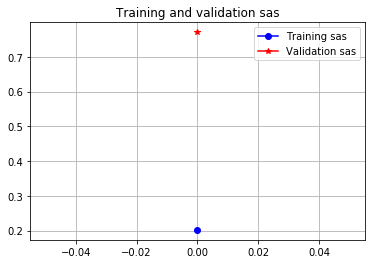

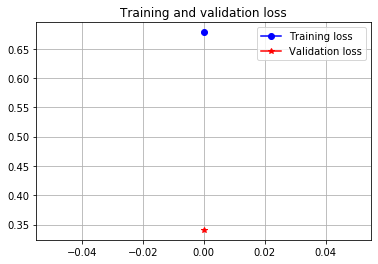

In [15]:
plot(epochs_range,sas,'bo-',label='Training sas')
plot(epochs_range,val_sas,'r*-',label='Validation sas')
title('Training and validation sas')
grid()
legend()

figure()
plot(epochs_range,loss,'bo-',label='Training loss')
plot(epochs_range,val_loss,'r*-',label='Validation loss')
title('Training and validation loss')
grid()
legend()

show()

In [16]:
model_file_dir = './models'
if not os.path.exists(model_file_dir):
    os.mkdir(model_file_dir)

count = len(os.listdir(model_file_dir)) + 1
print(count)

new_file_path = '%s/model_%03d_epochs_%d.h5' % (model_file_dir, count,  epochs)
print(new_file_path)

network.save(new_file_path)

7
./models/model_007_epochs_1.h5


In [17]:
labels = test_generator.classes

In [18]:
%%time
predicted = network.predict_generator(test_generator, workers=4)

Wall time: 14.6 s


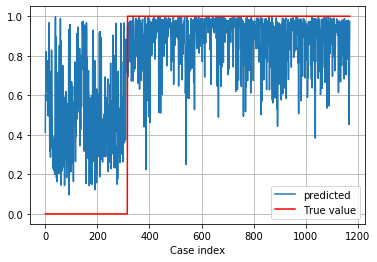

In [19]:
plot(predicted, label='predicted')
plot(labels, 'r', label='True value')
legend()
xlabel('Case index')
grid()
show()

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

print('Confusion matrix (machine learning way): ')
cm = confusion_matrix(labels, predicted > 0.5)
print(cm)
print('Confusion matrix (actual medicine way): ')
print(cm.T)

Confusion matrix (machine learning way): 
[[159 157]
 [ 10 844]]
Confusion matrix (actual medicine way): 
[[159  10]
 [157 844]]


In [21]:
cr = classification_report(labels, predicted > 0.5, target_names=['Normal (0)','Pneumonia (1)'])
print(cr)

               precision    recall  f1-score   support

   Normal (0)       0.94      0.50      0.66       316
Pneumonia (1)       0.84      0.99      0.91       854

     accuracy                           0.86      1170
    macro avg       0.89      0.75      0.78      1170
 weighted avg       0.87      0.86      0.84      1170



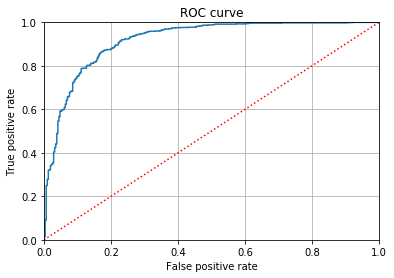

In [22]:
fpr, tpr, tresholds = roc_curve(labels, predicted, pos_label=1)

plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0,1])
ylim([0,1])
grid()
show()